In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from svd_compression import calculate_singular_values, compress_matrix

In [12]:
def random_matrix(n, p=0):
    r_matrix = np.random.uniform(0, 1, (n, n))
    for ind in np.random.permutation(range(n*n))[:int(n*n*p)]:
        r_matrix[ind // n, ind % n] = 0
    return r_matrix

In [13]:
def plot_singular_values(values):
    plt.title('Singular values')
    plt.plot(values)

In [14]:
eps = 1e-12

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


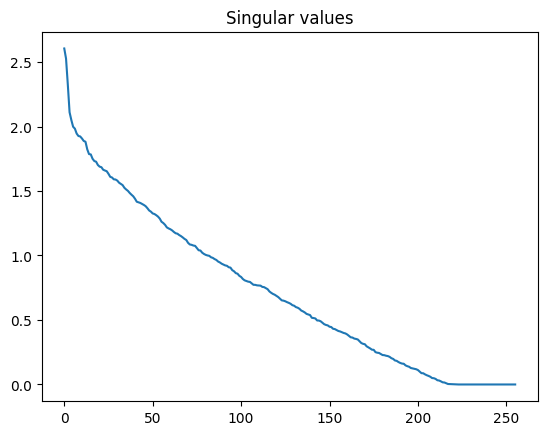

In [15]:
mat = random_matrix(256, 0.99)
v = calculate_singular_values(mat)
plot_singular_values(v)
print(mat)

In [30]:
tree = compress_matrix(mat, v[128], 4)
mat2 = tree.eval()
print(np.max(mat2 - mat))

0.29117748413287453


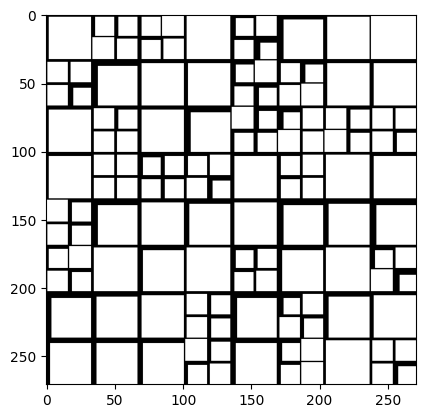

In [31]:
plt.imshow(Image.fromarray(tree.draw()))

# Testy

In [47]:
import time

In [48]:
size = 2 ** 10
zeros_percentage = [0.99, 0.98, 0.95, 0.9, 0.8]

In [49]:
results = []

Zeros percentage: 99.0 %


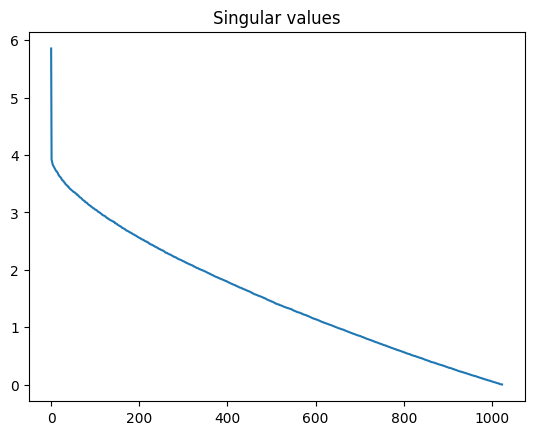

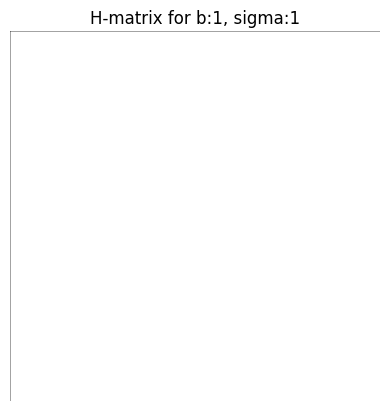

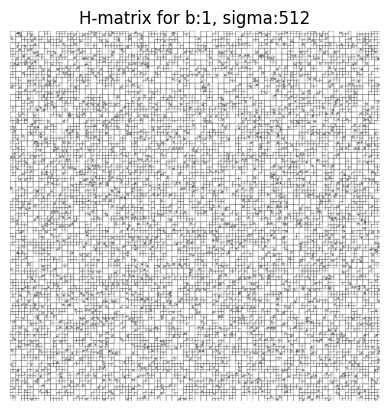

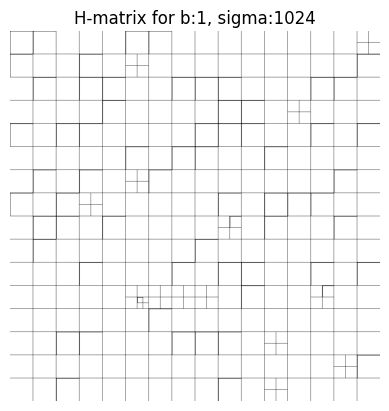

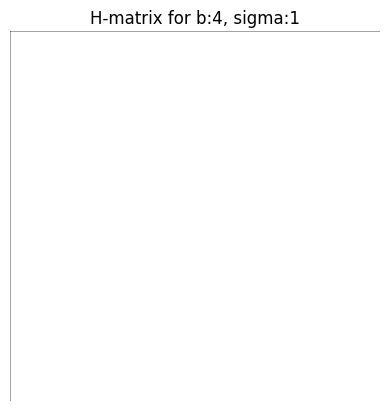

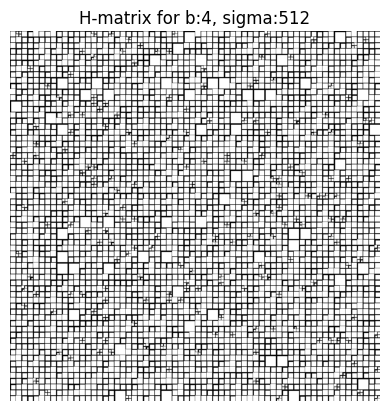

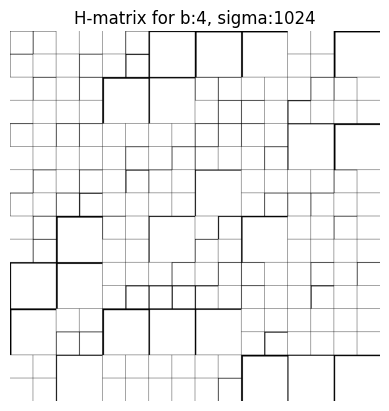

Zeros percentage: 98.0 %


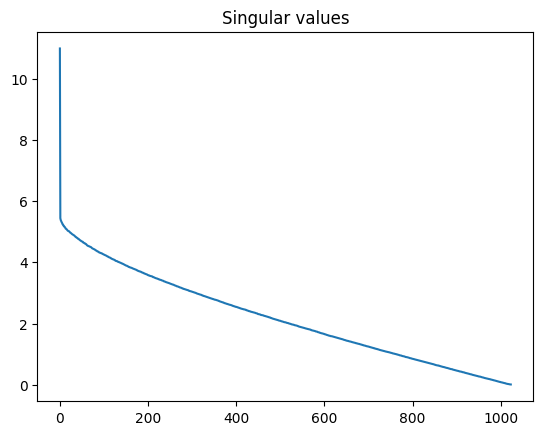

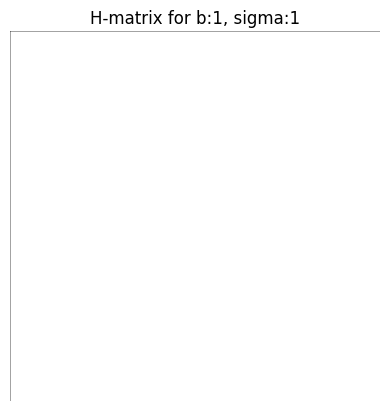

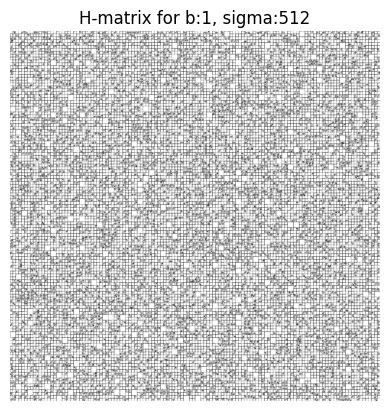

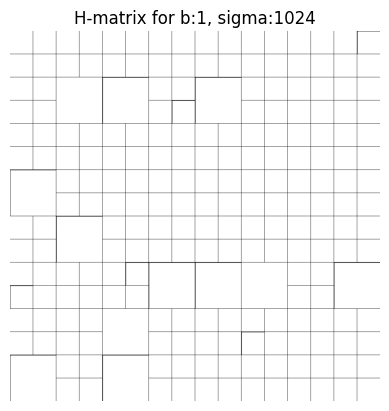

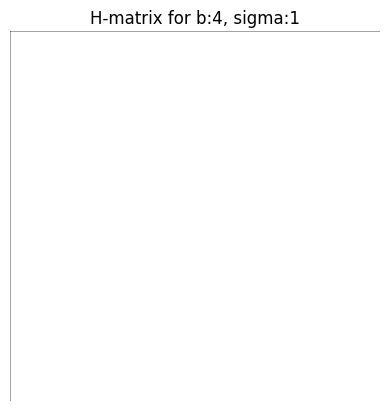

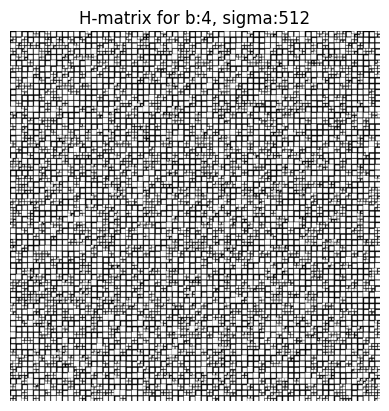

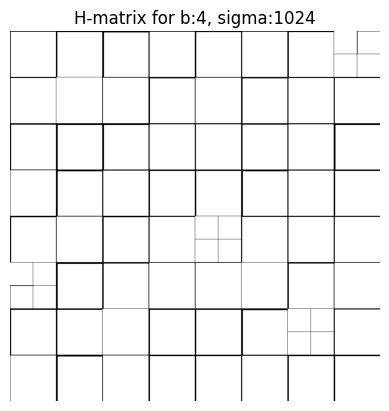

Zeros percentage: 95.0 %


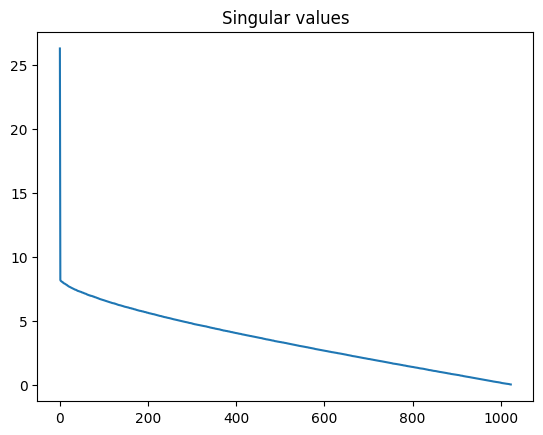

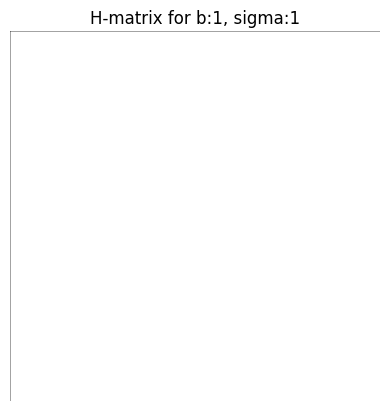

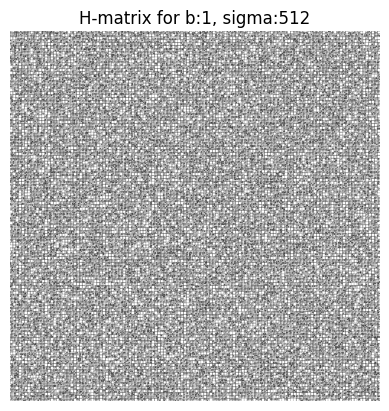

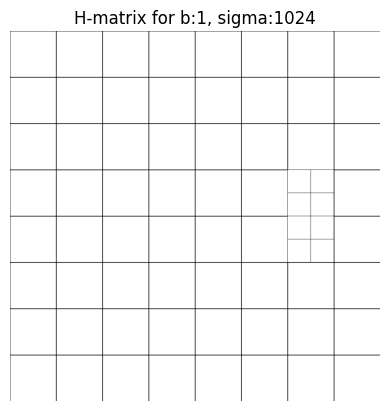

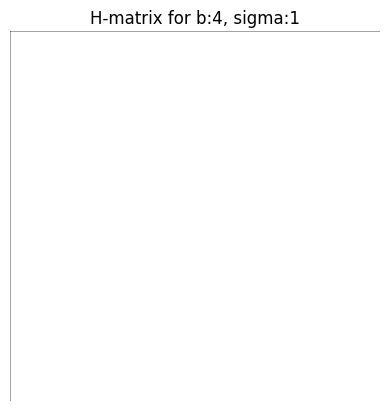

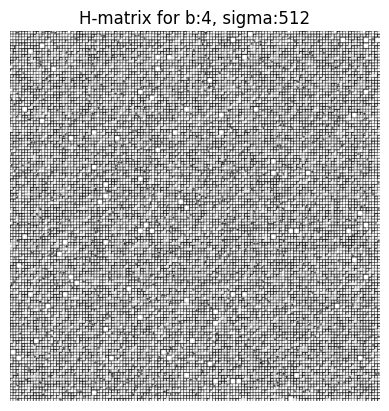

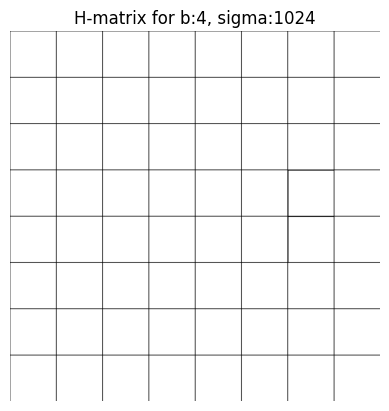

Zeros percentage: 90.0 %


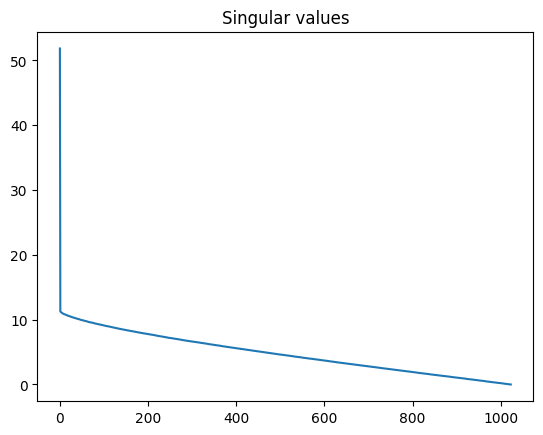

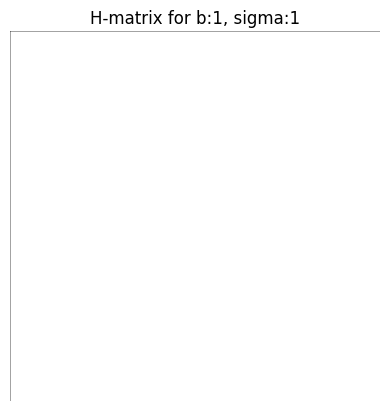

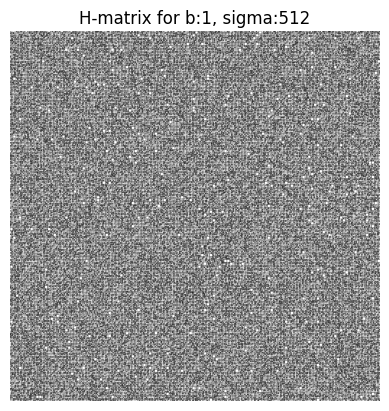

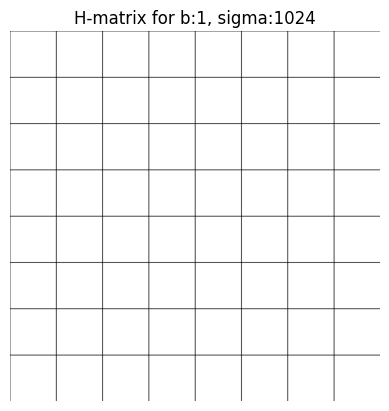

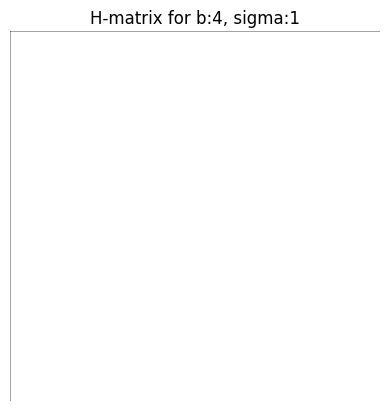

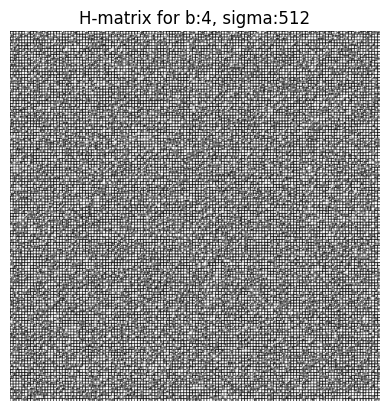

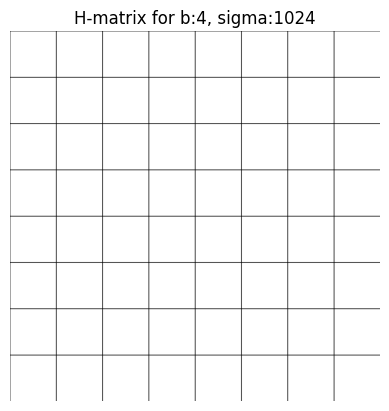

Zeros percentage: 80.0 %


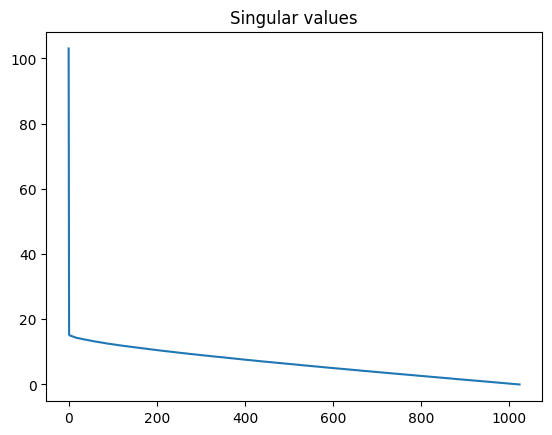

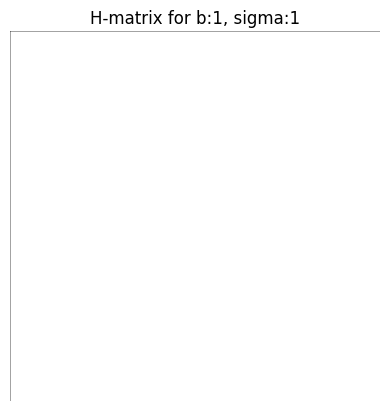

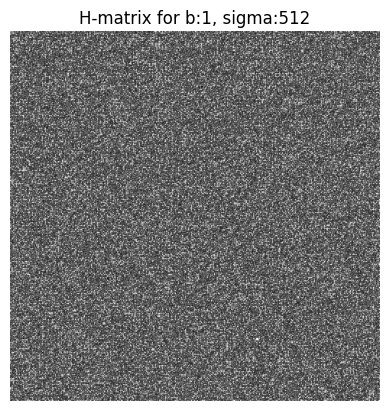

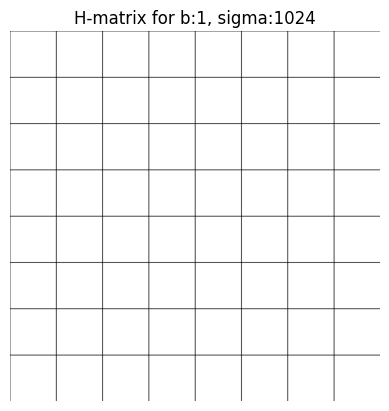

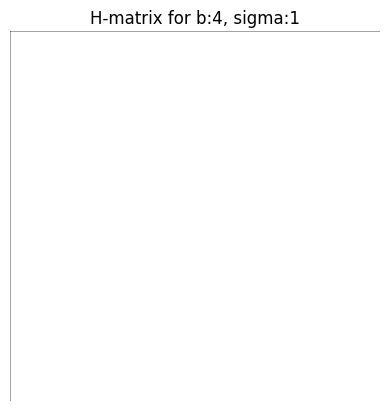

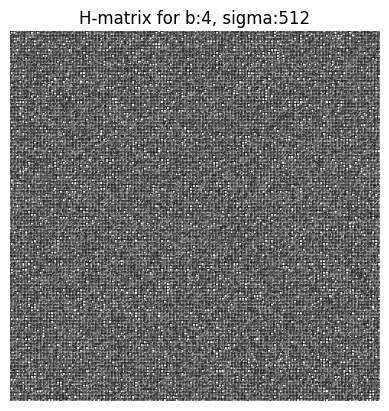

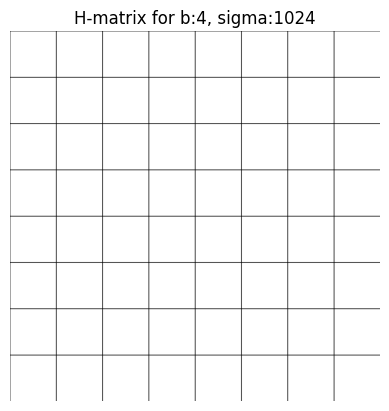

In [50]:
singular_indices = [1, 512, 1024]
for zeros_p in zeros_percentage:
    print('Zeros percentage:', zeros_p * 100, '%')
    matrix = random_matrix(size, zeros_p)
    
    singular_values = calculate_singular_values(matrix)
    
    plot_singular_values(singular_values)
    plt.savefig(f"saved_figures/singular_values_sparse{zeros_p}.png")
    plt.show()
    
    b_values = [1, 4]
    delta_values = [singular_values[1], singular_values[-1], singular_values[len(singular_values) // 2]]
    
    for b in b_values:
        for i, delta in enumerate(delta_values):
            time_start = time.time()
            root = compress_matrix(matrix, delta, b)
            time_stop = time.time()
            
            image = root.draw()
            plt.imshow(image)
            plt.title(f'H-matrix for b:{b}, sigma:{singular_indices[i]}')
            # plt.gray()
            plt.axis('off')
            plt.savefig(f"saved_figures/rank_{b}_delta_{i}_sparse_{zeros_p}.png")
            plt.show()
            
            decompressed_matrix = root.eval()
            norm = np.linalg.norm(matrix - decompressed_matrix) ** 2
            
            results.append((zeros_p, b, delta, time_stop - time_start, norm))

In [52]:
import pandas as pd

dataframe = pd.DataFrame(results, columns=['Zeros number', 'Max rank', 'Delta', 'Compress time', 'Norm of difference'])

print(dataframe)

    Zeros number  Max rank      Delta  Compress time  Norm of difference
0           0.99         1   3.915814       0.150578         3479.470245
1           0.99         1   0.002196      14.657351            0.000036
2           0.99         1   1.406898       3.109906         3360.245983
3           0.99         4   3.915814       0.228737         3479.470245
4           0.99         4   0.002196       7.481430            0.000035
5           0.99         4   1.406898       3.482326         3175.621805
6           0.98         1   5.443215       0.186192         6886.181377
7           0.98         1   0.006911      22.125296            0.002079
8           0.98         1   2.037275       3.120790         6939.954720
9           0.98         4   5.443215       0.169572         6886.181377
10          0.98         4   0.006911       9.719449            0.001712
11          0.98         4   2.037275       2.892564         6300.105302
12          0.95         1   8.187151       0.16608